In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.resnest import ResNeSt
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/resnest")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

In [9]:
dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [10]:
len(dataset)

26179

cavallo


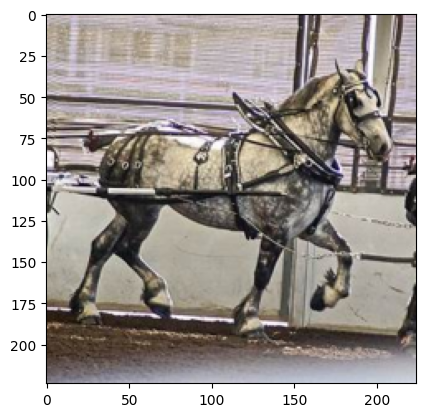

In [11]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [12]:
model = ResNeSt(output_size=num_class, key=50).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
ResNeSt                                                      --
├─Sequential: 1-1                                            --
│    └─ConvBnRelu: 2-1                                       --
│    │    └─Conv2d: 3-1                                      9,408
│    │    └─BatchNorm2d: 3-2                                 128
│    │    └─ReLU: 3-3                                        --
│    └─MaxPool2d: 2-2                                        --
├─Sequential: 1-2                                            --
│    └─ResBlock: 2-3                                         --
│    │    └─BottleNeck: 3-4                                  64,576
│    │    └─ConvBnRelu: 3-5                                  16,896
│    └─ResBlock: 2-4                                         --
│    │    └─BottleNeck: 3-6                                  76,864
│    │    └─Identity: 3-7                                    --
│    └─ResBlock: 2-

# training

In [14]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [15]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [16]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [05:55<00:00,  4.61it/s]


epoch 1 : 0.03016434359753591


100%|██████████| 1636/1636 [05:46<00:00,  4.72it/s]


epoch 2 : 0.022839367866725604


100%|██████████| 1636/1636 [05:39<00:00,  4.82it/s]


epoch 3 : 0.01868157498714967


100%|██████████| 1636/1636 [05:27<00:00,  5.00it/s]


epoch 4 : 0.015721008604538143


100%|██████████| 1636/1636 [05:34<00:00,  4.90it/s]


epoch 5 : 0.01372633712331498


100%|██████████| 1636/1636 [05:43<00:00,  4.77it/s]


epoch 6 : 0.012296330863308199


100%|██████████| 1636/1636 [05:23<00:00,  5.06it/s]


epoch 7 : 0.010855028839140884


100%|██████████| 1636/1636 [05:20<00:00,  5.10it/s]


epoch 8 : 0.009661026085737733


100%|██████████| 1636/1636 [05:28<00:00,  4.98it/s]


epoch 9 : 0.008773403028861624


100%|██████████| 1636/1636 [05:28<00:00,  4.98it/s]

epoch 10 : 0.00810623048979181


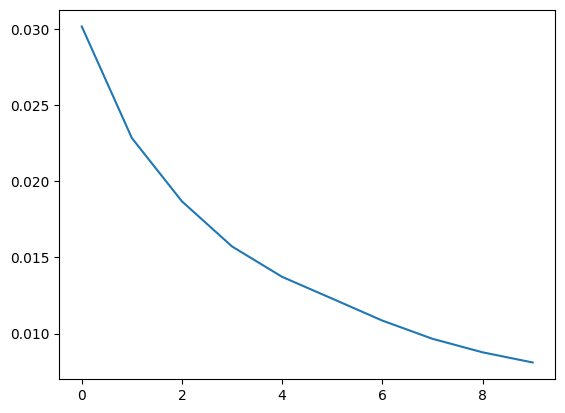

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [20]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:45<00:00,  9.88it/s]

[[4385   67   11    1   23  118   53   54   58   93]
 [ 197 2175   11    4   10   11  125   39   29   22]
 [  93   39 1131    0   12    9   66   24   21   51]
 [  73    3    0 1592   25    9    6    1  365   38]
 [ 233    5    4    4 2715   16   15   14   56   36]
 [ 190    5    4    2    9 1309    7    6   15  121]
 [ 132   58    9    0   11    8 1565   60   10   13]
 [ 116   23   30    0   27   11  188 1352   16   57]
 [  31    3    0   13   11    9    5    5 4672   72]
 [  66    8    1    0   13   20    2   12   49 1691]]


In [24]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.90170676537117
cavallo   : 0.8292032024399543
elefante  : 0.7821576763485477
farfalla  : 0.7537878787878788
gallina   : 0.8763718528082634
gatto     : 0.7847721822541966
mucca     : 0.8386923901393355
pecora    : 0.7428571428571429
ragno     : 0.9690935490562124
scoiattolo: 0.9081632653061225


In [25]:
per_class_acc.mean()

0.8386805905368824

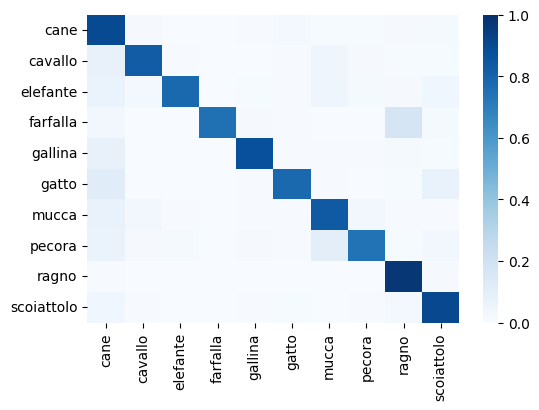

In [26]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [27]:
# image from internet
import requests
from io import BytesIO
from PIL import Image

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [28]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

mucca


In [29]:
model_path = artifact_path / 'resnest50.pth'

In [30]:
torch.save(model.state_dict(), model_path)

In [31]:
get_file_size(model_path)

'97.43MB'

In [32]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>